<a href="https://colab.research.google.com/github/Osama00112/Business-Data-Analytics/blob/main/task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fetching data from cloud

In [22]:
!pip install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d osamahaque/transaction-narration
!unzip transaction-narration.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 98% 215M/218M [00:02<00:00, 96.8MB/s]
100% 218M/218M [00:02<00:00, 79.5MB/s]
Archive:  transaction-narration.zip
  inflating: Transaction_Naration_Data_Set.csv  


## Importing necessary libraries

In [23]:
import numpy as np
import pandas as pd
import nltk
import itertools
import collections
import matplotlib.pyplot as plt
import spacy
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import words
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

## Cleaning the texts (lowering, removing links, punctuaions and numbers)

In [24]:
# Read the CSV file
narrations = pd.read_csv('Transaction_Naration_Data_Set.csv')

narrations = narrations.drop_duplicates(subset='NARATION')
narrations['NARATION'] = narrations['NARATION'].fillna("")
# Select and preprocess the 'NARATION' column
narrations['NARATION'] = narrations['NARATION'].str.lower()
#narrations['NARATION'] = narrations['NARATION'].str.replace('[^A-Za-z0-9]+', ' ', regex=True)
narrations['NARATION'] = narrations['NARATION'].str.replace('[^A-Za-z ]+', '', regex=True)

<ipython-input-24-74af8cd45fae>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  narrations['NARATION'] = narrations['NARATION'].fillna("")
<ipython-input-24-74af8cd45fae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  narrations['NARATION'] = narrations['NARATION'].str.lower()


In [27]:
narrations.head()
len(narrations)

128604

In [28]:
# Get the set of stopwords
stopword_set = set(stopwords.words('english'))

# Apply stopword removal to the 'NARATION' column
narrations['NARATION'] = narrations['NARATION'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in stopword_set]))


In [29]:
narrations.head()

,Unnamed: 0,AC_ID,AMOUNT,DOC_DATE,NARATION,DR_CR
0,0,3644877,342800.0,01-NOV-22,cash withdraw,Debit
1,1,1175256,342800.0,01-NOV-22,cash withdrawal ac,Credit
2,2,2298226,1500.0,01-NOV-22,cash withdraw micro merchant point mm ac,Debit
3,3,4066427,1500.0,01-NOV-22,credit merchant cash withdraw service ac,Credit
6,6,38418,500.0,01-NOV-22,cash deposit ac,Debit


In [30]:
# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Function to map POS tags to WordNet tags
def get_wordnet_pos(token):
    tag = nltk.pos_tag([token])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
narrations = narrations['NARATION'].unique()
narrations = pd.DataFrame(narrations, columns=['NARATION'])
print(len(narrations))

98328


## Tokenize, stem, and lemmatize the text

In [31]:
narrations['tokenized_texts'] = narrations['NARATION'].astype(str).apply(word_tokenize)
narrations['lemmatized_texts'] = narrations['tokenized_texts'].apply(lambda x: [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in x])

## Checking word frequencies (Initially)

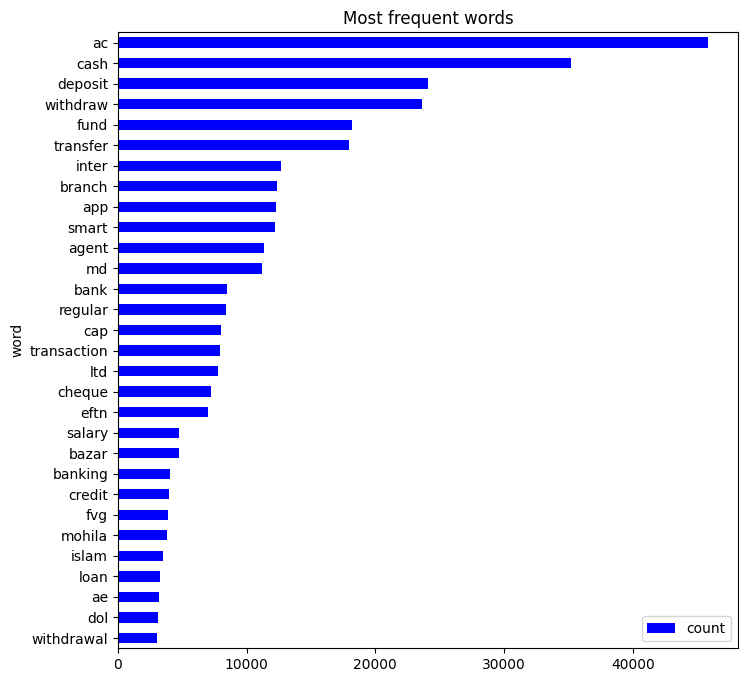

In [32]:
lemmatized = list(narrations['lemmatized_texts'])
token_list = list(itertools.chain(*lemmatized))
counts_no = collections.Counter(token_list)
clean_texts = pd.DataFrame(counts_no.most_common(30), columns = ['word', 'count'])
fig, ax = plt.subplots(figsize = (8,8))
clean_texts.sort_values(by = 'count').plot.barh(x='word', y='count', ax=ax, color='blue')
ax.set_title("Most frequent words")
plt.show()

## Remove stopwords from lemmatized_texts

In [33]:
# Get the set of stopwords
stopword_set = set(stopwords.words('english'))
# Define the words to be removed
words_to_remove = ['quarterly', 'weekly', 'th', 'shahin', 'gate', 'm', 'february',
                   'jun', 'ae', 'omer', 'dey', 'hasan', 'mar', 'type', 'b', 'kazi',
                   'year', 'month', 'mullah', 'amt', 'p', 'july', 'palli', 'cotton',
                   'rani', 'daily', 'sultana', 'shah', 'oct', 'dor', 'first', 'tara',
                   'tala', 'november', 'k', 'august', 'jul', 'ad', 'october', 'x',
                   'orient', 'auto', 'puja', 'point', 'daud', 'noon', 'doll', 'bin',
                   'ba', 'feb', 'nid', 'sheik', 'sec', 'pu', 'patwari', 'kokan', 'mu',
                   'id', 'bakula', 'babu', 'sima', 'doc', 'sha', 'da', 'maria', 'nov',
                   'two', 'outlet', 'may', 'tapu', 'jan', 'fakir', 'ghat', 'monthly',
                   'kaka', 'april', 'amin', 'china', 'hanif', 'bu', 'e', 'pally',
                   'begum', 'ar', 'service', 'today', 'gore', 'dal', 'c', 'total',
                   'link', 'i', 'september', 'june', 'chad', 'jowel', 'yesterday',
                   'l', 'dada', 'momo', 'sep', 'martin', 'december', 'das', 'dola',
                   'sri', 'say', 'boro', 'barman', 'abu', 'mir', 'ink', 'annual',
                   'ka', 'st', 'ge', 'raj', 'hour', 'shanghai', 'sir', 'date', 'son',
                   'razor', 'mother', 'mo', 'rana', 'march', 'name', 'coxs', 'pur',
                   'week', 'second', 'nandi', 'tania', 'eighteen', 'german', 'title',
                   'currier', 'twelve', 'southeast', 'fifteen', 'nova', 'bas', 
                   'amenia', 'bari', 'new', 'fourteen', 'rocky', 'para', 'brother',
                   'amir', 'al', 'japan', 'tony', 'road', 'khan', 'na', 'u', 'january',
                   'saddik', 'bibi', 'zero', 'dec', 'r', 'mim', 'apr', 'aug', 'sweety']

stopwords_set = set(stopwords.words('english'))

# Add the words to be removed to the stopwords set
stopwords_set.update(words_to_remove)

## Removing prepositions

In [34]:
# Define a list of prepositions
prepositions_list = [
    'aboard', 'about', 'above', 'across', 'after', 'against', 'along',
    'amid', 'among', 'around', 'as', 'at', 'before', 'behind', 'below',
    'beneath', 'beside', 'between', 'beyond', 'but', 'by', 'concerning',
    'considering', 'despite', 'down', 'during', 'except',
    'in', 'inside', 'into', 'like', 'near', 'of', 'off', 'on', 'onto', 'out',
    'outside', 'over', 'past', 'regarding', 'round', 'since',
    'throughout', 'toward', 'under', 'underneath', 'until', 'unto',
    'up', 'upon', 'with', 'within', 'without', 'ali', 'mamun','vai'
]

# Add prepositions to the stopwords set
stopwords_set.update(prepositions_list)

In [35]:
# Removing stopwords from the tokens
narrations['lemmatized_texts2'] = narrations['lemmatized_texts'].apply(lambda x: [token for token in x if token.lower() not in stopwords_set])

## Convering some words to single form to remove duplicates

In [36]:
narrations['lemmatized_texts2'] = narrations['lemmatized_texts2'].apply(lambda x: ['deposit' if token.startswith('deposit') else token for token in x])


# converting all "withdrawal" to "withdraw"
narrations['lemmatized_texts2'] = narrations['lemmatized_texts2'].apply(lambda x: ['withdraw' if token == 'withdrawal' else token for token in x])
# # converting all "banking" to "bank"
narrations['lemmatized_texts2'] = narrations['lemmatized_texts2'].apply(lambda x: ['bank' if token == 'banking' else token for token in x])
# # converting all "mob" to "mobile"
narrations['lemmatized_texts2'] = narrations['lemmatized_texts2'].apply(lambda x: ['mobile' if token == 'mob' else token for token in x])
# # converting all "br" to "branch"
narrations['lemmatized_texts2'] = narrations['lemmatized_texts2'].apply(lambda x: ['branch' if token == 'br' else token for token in x])


narrations['lemmatized_texts2'] = narrations['lemmatized_texts2'].apply(lambda x: ['unnayan' if token == 'unnayon' else token for token in x])

narrations['lemmatized_texts2'] = narrations['lemmatized_texts2'].apply(lambda x: ['unnayan' if token == 'unnoyon' else token for token in x])

narrations['lemmatized_texts2'] = narrations['lemmatized_texts2'].apply(lambda x: ['acount' if token == 'ac' else token for token in x])


narrations['lemmatized_texts2'] = narrations['lemmatized_texts2'].apply(lambda x: ['deposit' if token == 'deposit/' else token for token in x])

# Remove one-letter tokens from lemmatized_texts2 column
narrations['lemmatized_texts2'] = [[token for token in tokens if len(token) > 1] for tokens in narrations['lemmatized_texts2']]


In [37]:
print(narrations)

          Unnamed: 0    AC_ID    AMOUNT   DOC_DATE  \
0                  0  3644877  342800.0  01-NOV-22   
1                  1  1175256  342800.0  01-NOV-22   
2                  2  2298226    1500.0  01-NOV-22   
3                  3  4066427    1500.0  01-NOV-22   
6                  6    38418     500.0  01-NOV-22   
...              ...      ...       ...        ...   
22538287    22538287  4010179   44900.0  29-APR-23   
22539045    22539045  4199653   20000.0  29-APR-23   
22539930    22539930  2389876     100.0  29-APR-23   
22543261    22543261  4817300   34000.0  29-APR-23   
22544595    22544595   789386     100.0  29-APR-23   

                                                   NARATION   DR_CR  \
0                                             cash withdraw   Debit   
1                                        cash withdrawal ac  Credit   
2                  cash withdraw micro merchant point mm ac   Debit   
3                  credit merchant cash withdraw service ac  Credit

## Ignoring specific words provided

In [38]:
# Filter the tokens to remove all unnecessary person names, places and words not in english dictionary except for some predefined specific words
specific_words = ['eftn', 'ft', 'bkash', 'nogod', 'rtgs', 'pos', 
                 'cib', 'paywell', 'challan', 'npsb', 'dps', 'atm', 'trf', 'sonod']

nltk.download('words')
nlp = spacy.load('en_core_web_sm')
english_words = set(words.words())
def is_english_word(word):
    return word.lower() in english_words or word in specific_words

# def is_english_word(word):
#     return word in specific_words or nlp(word.lower()).vocab and nlp.vocab[word.lower()].lang_ == 'en'



tokenized_texts = narrations['lemmatized_texts2'].tolist()

filtered_texts = [[word for word in text if is_english_word(word)] for text in tokenized_texts]

# Update narrations DataFrame with the filtered texts
narrations['filtered_texts'] = filtered_texts

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [39]:
# Drop unnecessary columns from the DataFrame
#narrations.drop(['tokenized_texts', 'lemmatized_texts'], axis=1, inplace=True)

# Print the reduced DataFrame
print(narrations)

          Unnamed: 0    AC_ID    AMOUNT   DOC_DATE  \
0                  0  3644877  342800.0  01-NOV-22   
1                  1  1175256  342800.0  01-NOV-22   
2                  2  2298226    1500.0  01-NOV-22   
3                  3  4066427    1500.0  01-NOV-22   
6                  6    38418     500.0  01-NOV-22   
...              ...      ...       ...        ...   
22538287    22538287  4010179   44900.0  29-APR-23   
22539045    22539045  4199653   20000.0  29-APR-23   
22539930    22539930  2389876     100.0  29-APR-23   
22543261    22543261  4817300   34000.0  29-APR-23   
22544595    22544595   789386     100.0  29-APR-23   

                                                   NARATION   DR_CR  \
0                                             cash withdraw   Debit   
1                                        cash withdrawal ac  Credit   
2                  cash withdraw micro merchant point mm ac   Debit   
3                  credit merchant cash withdraw service ac  Credit

## Removing empty tokens

In [68]:
narrations = narrations[narrations['filtered_texts'].apply(lambda x: len(x) > 0)]
tokenized_texts = narrations['filtered_texts'].tolist()
filtered_texts = [[word for word in text if is_english_word(word)] for text in tokenized_texts]

print(narrations)

          Unnamed: 0    AC_ID    AMOUNT   DOC_DATE  \
0                  0  3644877  342800.0  01-NOV-22   
1                  1  1175256  342800.0  01-NOV-22   
2                  2  2298226    1500.0  01-NOV-22   
3                  3  4066427    1500.0  01-NOV-22   
6                  6    38418     500.0  01-NOV-22   
...              ...      ...       ...        ...   
22536013    22536013   652566    2600.0  29-APR-23   
22536483    22536483  5418855   36000.0  29-APR-23   
22538051    22538051  5418855    5600.0  29-APR-23   
22539045    22539045  4199653   20000.0  29-APR-23   
22539930    22539930  2389876     100.0  29-APR-23   

                                                   NARATION   DR_CR  \
0                                             cash withdraw   Debit   
1                                        cash withdrawal ac  Credit   
2                  cash withdraw micro merchant point mm ac   Debit   
3                  credit merchant cash withdraw service ac  Credit

## Checking frequency again

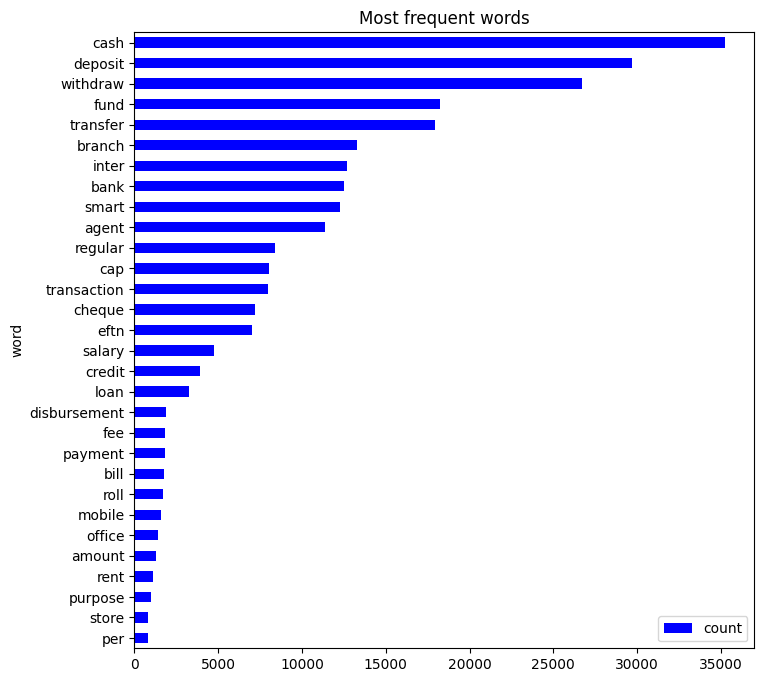

In [70]:
lemmatized = list(narrations['filtered_texts'])
token_list = list(itertools.chain(*lemmatized))
counts_no = collections.Counter(token_list)
clean_texts = pd.DataFrame(counts_no.most_common(30), columns = ['word', 'count'])
fig, ax = plt.subplots(figsize = (8,8))
clean_texts.sort_values(by = 'count').plot.barh(x='word', y='count', ax=ax, color='blue')
ax.set_title("Most frequent words")
plt.show()

## Feature Engineering
### Word2Vec

In [71]:
model = Word2Vec(filtered_texts, vector_size=100, window=5, min_count=1, workers=4)

word_vectors = model.wv
# Step 4: Apply clustering algorithm (K-means)
num_clusters = range(10, 20)
inertias = []

In [72]:
for k in num_clusters:
    kmeans = KMeans(n_clusters=k, n_init = 10)
    kmeans.fit(word_vectors.vectors)
    inertias.append(kmeans.inertia_)

## Elbow method to determine optimal number of clusters

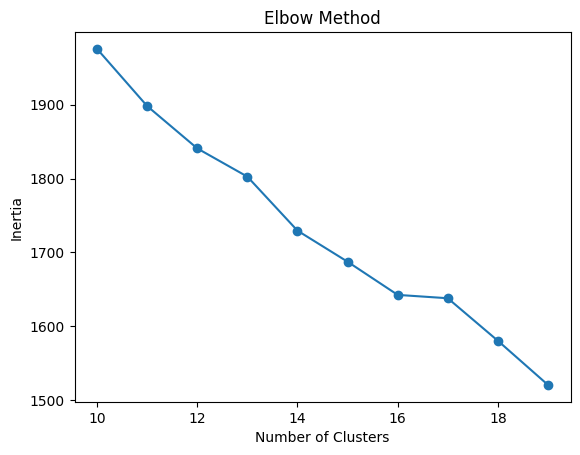

In [73]:
# Step 5: Elbow method to determine optimal number of clusters
plt.plot(num_clusters, inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

## Silhoette score to determine optimal cluster count

In [ ]:
# Train Word2Vec model on filtered texts
#model = Word2Vec(filtered_texts, min_count=1)

# Get the word vectors
word_vectors = model.wv

# Convert each narration to a vector representation by averaging the word vectors
narration_vectors = []
for text in filtered_texts:
    vectors = [word_vectors[word] for word in text if word in word_vectors]
    if vectors:
        narration_vectors.append(np.mean(vectors, axis=0))
    else:
        # If no valid word vectors found, append a vector of zeros
        narration_vectors.append(np.zeros(model.vector_size))

# Convert the narration vectors to a numpy array
narration_vectors = np.array(narration_vectors)

# Perform KMeans clustering
range_n_clusters = range(11, 21)  # Define the range of cluster numbers to try
best_silhouette_score = -1
best_n_clusters = -1

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, n_init = 10, random_state=42)
    cluster_labels = kmeans.fit_predict(narration_vectors)
    silhouette_avg = silhouette_score(narration_vectors, cluster_labels)
    
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_n_clusters = n_clusters

print("Best number of clusters:", best_n_clusters)
print(best_n_clusters)


Best number of clusters: 19
19


In [74]:
best_n_clusters = 13

## Kmeans Clustering

In [75]:
# Train Word2Vec model on filtered texts
#model = Word2Vec(filtered_texts, min_count=1)

# Get the word vectors
word_vectors = model.wv

# Convert each narration to a vector representation by averaging the word vectors
narration_vectors = []
for text in filtered_texts:
    vectors = [word_vectors[word] for word in text if word in word_vectors]
    if vectors:
        narration_vectors.append(np.mean(vectors, axis=0))
    else:
        # If no valid word vectors found, append a vector of zeros
        narration_vectors.append(np.zeros(model.vector_size))

# Convert the narration vectors to a numpy array
narration_vectors = np.array(narration_vectors)

In [81]:
KMeans_cluster_size = best_n_clusters

# Perform clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=best_n_clusters, n_init = best_n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(narration_vectors)

## Words histogram per cluster

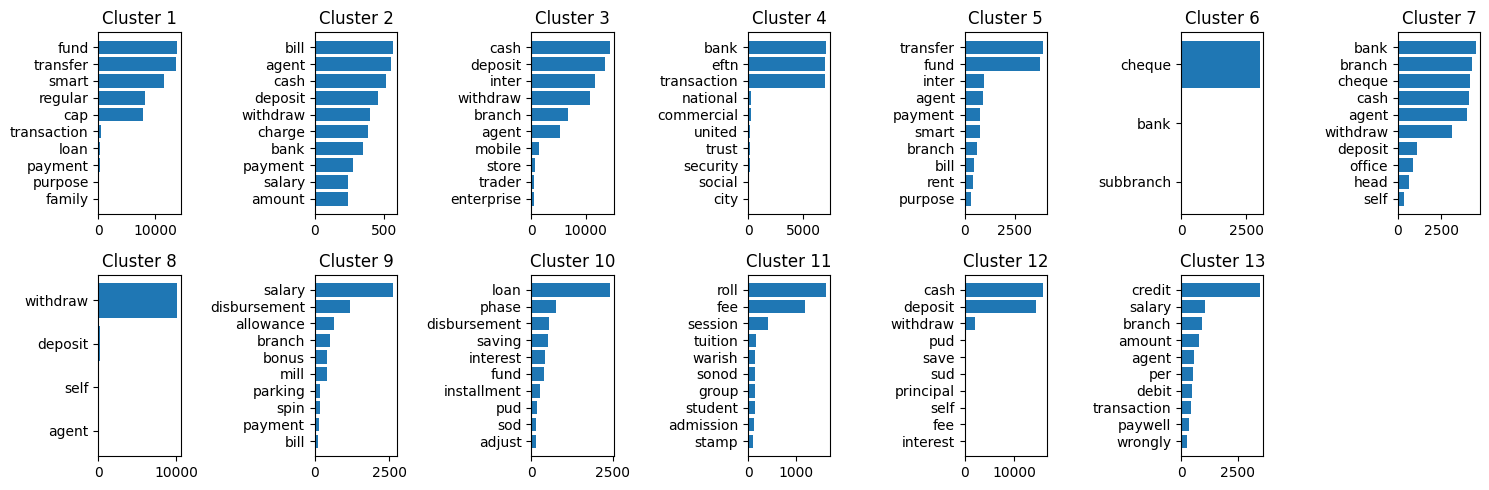

In [82]:
# Get the top 10 words in each cluster
top_words_per_cluster = []

for cluster in range(KMeans_cluster_size):
    # Get the indices of narratives belonging to the current cluster
    cluster_indices = np.where(cluster_labels == cluster)[0]
    
    # Flatten the narratives in the cluster
    cluster_narratives = [filtered_texts[i] for i in cluster_indices]
    cluster_narratives = list(itertools.chain(*cluster_narratives))
    
    # Count the occurrences of each word
    word_counts = collections.Counter(cluster_narratives)
    
    # Get the top 10 words in the cluster
    top_words = word_counts.most_common(10)
    top_words_per_cluster.append(top_words)

# Plot the histogram for each cluster
fig, axs = plt.subplots(KMeans_cluster_size // 7 + 1, 7, figsize=(15, 2.5 * (KMeans_cluster_size // 7 + 1)))

for i, top_words in enumerate(top_words_per_cluster):
    row = i // 7
    col = i % 7
    
    words = [word for word, count in top_words]
    counts = [count for word, count in top_words]
    
    axs[row, col].barh(words, counts)
    axs[row, col].set_title('Cluster {}'.format(i + 1))
    axs[row, col].invert_yaxis()

# Remove empty subplots
if KMeans_cluster_size % 7 != 0:
    for j in range(KMeans_cluster_size % 7, 7):
        fig.delaxes(axs[-1, j])

plt.tight_layout()
plt.show()


In [65]:
print(narrations)

          Unnamed: 0    AC_ID    AMOUNT   DOC_DATE  \
0                  0  3644877  342800.0  01-NOV-22   
1                  1  1175256  342800.0  01-NOV-22   
2                  2  2298226    1500.0  01-NOV-22   
3                  3  4066427    1500.0  01-NOV-22   
6                  6    38418     500.0  01-NOV-22   
...              ...      ...       ...        ...   
22536013    22536013   652566    2600.0  29-APR-23   
22536483    22536483  5418855   36000.0  29-APR-23   
22538051    22538051  5418855    5600.0  29-APR-23   
22539045    22539045  4199653   20000.0  29-APR-23   
22539930    22539930  2389876     100.0  29-APR-23   

                                                   NARATION   DR_CR  \
0                                             cash withdraw   Debit   
1                                        cash withdrawal ac  Credit   
2                  cash withdraw micro merchant point mm ac   Debit   
3                  credit merchant cash withdraw service ac  Credit

In [83]:
len(kmeans.labels_)

104726

## Storing the results into different datset

In [84]:
df_clusters_KMeans = pd.DataFrame({
    "narrations": narrations['NARATION'],
    "tokens": narrations['filtered_texts'],
    "kmeans_cluster": kmeans.labels_
})

df_clusters_KMeans

,narrations,tokens,kmeans_cluster
0,cash withdraw,"[cash, withdraw]",11
1,cash withdrawal ac,"[cash, withdraw]",11
2,cash withdraw micro merchant point mm ac,"[cash, withdraw, micro, merchant]",2
3,credit merchant cash withdraw service ac,"[credit, merchant, cash, withdraw]",2
6,cash deposit ac,"[cash, deposit]",11
...,...,...,...
22536013,smart app fund transfer wife dps money,"[smart, fund, transfer, wife, money]",0
22536483,cash deposit suraighat bazar sme,"[cash, deposit]",11
22538051,cash deposit raigor mohila dol,"[cash, deposit]",11
22539045,transaction fund transfer smart app regular fu...,"[transaction, fund, transfer, smart, regular, ...",0


## Extracting top 5 words from the clusters

In [85]:
import pandas as pd
import itertools
import collections

# Define the number of clusters
KMeans_cluster_size = 14

# Initialize a list to store the top words per cluster
top_words_per_cluster = []

# Iterate over each cluster
for cluster in range(KMeans_cluster_size):
    # Get the indices of narratives belonging to the current cluster
    cluster_indices = df_clusters_KMeans[df_clusters_KMeans['kmeans_cluster'] == cluster].index
    
    # Flatten the narratives in the cluster
    cluster_narratives = list(itertools.chain.from_iterable(df_clusters_KMeans.loc[cluster_indices, 'tokens']))
    
    # Count the occurrences of each word
    word_counts = collections.Counter(cluster_narratives)
    
    # Get the top 5 words in the cluster
    top_words = word_counts.most_common(5)
    top_words_per_cluster.append(top_words)

# Create a list to store the top words for each narrative
top_words_list = []

# Iterate over each row in the DataFrame
for index, row in df_clusters_KMeans.iterrows():
    cluster = row['kmeans_cluster']
    top_words = top_words_per_cluster[cluster]
    top_words_list.append([word for word, count in top_words])

# Add the top words column to the DataFrame
df_clusters_KMeans['top_words'] = top_words_list


In [86]:
df_clusters_KMeans

,narrations,tokens,kmeans_cluster,top_words
0,cash withdraw,"[cash, withdraw]",11,"[cash, deposit, withdraw, pud, save]"
1,cash withdrawal ac,"[cash, withdraw]",11,"[cash, deposit, withdraw, pud, save]"
2,cash withdraw micro merchant point mm ac,"[cash, withdraw, micro, merchant]",2,"[cash, deposit, inter, withdraw, branch]"
3,credit merchant cash withdraw service ac,"[credit, merchant, cash, withdraw]",2,"[cash, deposit, inter, withdraw, branch]"
6,cash deposit ac,"[cash, deposit]",11,"[cash, deposit, withdraw, pud, save]"
...,...,...,...,...
22536013,smart app fund transfer wife dps money,"[smart, fund, transfer, wife, money]",0,"[fund, transfer, smart, regular, cap]"
22536483,cash deposit suraighat bazar sme,"[cash, deposit]",11,"[cash, deposit, withdraw, pud, save]"
22538051,cash deposit raigor mohila dol,"[cash, deposit]",11,"[cash, deposit, withdraw, pud, save]"
22539045,transaction fund transfer smart app regular fu...,"[transaction, fund, transfer, smart, regular, ...",0,"[fund, transfer, smart, regular, cap]"


In [87]:
final_clusters = pd.DataFrame({
    "narrations": narrations['NARATION'],
    "tokens": narrations['filtered_texts'],
    "kmeans_cluster": kmeans.labels_,
    "kmeans_keywords_per_cluster": df_clusters_KMeans['top_words']
})
    
final_clusters

,narrations,tokens,kmeans_cluster,kmeans_keywords_per_cluster
0,cash withdraw,"[cash, withdraw]",11,"[cash, deposit, withdraw, pud, save]"
1,cash withdrawal ac,"[cash, withdraw]",11,"[cash, deposit, withdraw, pud, save]"
2,cash withdraw micro merchant point mm ac,"[cash, withdraw, micro, merchant]",2,"[cash, deposit, inter, withdraw, branch]"
3,credit merchant cash withdraw service ac,"[credit, merchant, cash, withdraw]",2,"[cash, deposit, inter, withdraw, branch]"
6,cash deposit ac,"[cash, deposit]",11,"[cash, deposit, withdraw, pud, save]"
...,...,...,...,...
22536013,smart app fund transfer wife dps money,"[smart, fund, transfer, wife, money]",0,"[fund, transfer, smart, regular, cap]"
22536483,cash deposit suraighat bazar sme,"[cash, deposit]",11,"[cash, deposit, withdraw, pud, save]"
22538051,cash deposit raigor mohila dol,"[cash, deposit]",11,"[cash, deposit, withdraw, pud, save]"
22539045,transaction fund transfer smart app regular fu...,"[transaction, fund, transfer, smart, regular, ...",0,"[fund, transfer, smart, regular, cap]"


In [ ]:
final_clusters.to_csv("all_result.csv")

## Vectorize function [Credit: Syed Jarullah Hisham]

In [106]:
def vectorize(preprocessed_test_data, model):
  """Generate vectors for list of documents using a Word Embedding

  Args:
      list_of_docs: List of documents
      model: Gensim's Word Embedding

  Returns:
      List of document vectors
  """
  features = []
  model = Word2Vec(filtered_texts, vector_size=100, window=5, min_count=1, workers=4)

  # Get the word vectors
  word_vectors = model.wv

  # Convert each test narration to a vector representation by averaging the word vectors
  test_narration_vectors = []
  for text in preprocessed_test_data:
      vectors = [word_vectors[word] for word in text if word in word_vectors]
      if vectors:
          test_narration_vectors.append(np.mean(vectors, axis=0))
      else:
          # If no valid word vectors found, append a vector of zeros
          test_narration_vectors.append(np.zeros(model.vector_size))

  # Convert the test narration vectors to a numpy array
  test_narration_vectors = np.array(test_narration_vectors)

  

  # word_vectors = model.wv

  # narration_vectors = []
  # for text in list_of_docs:
  #     vectors = [word_vectors[word] for word in text if word in word_vectors]
  #     if vectors:
  #         narration_vectors.append(np.mean(vectors, axis=0))
  #     else:
  #         # If no valid word vectors found, append a vector of zeros
  #         narration_vectors.append(np.zeros(model.vector_size))

  # # Convert the narration vectors to a numpy array
  # narration_vectors = np.array(narration_vectors)

  return test_narration_vectors
    


In [89]:
vectorized_docs = vectorize(narrations['filtered_texts'], model=gensim_model)
len(vectorized_docs), len(vectorized_docs[0])

(104726, 100)

## preprocess function

In [90]:
# Filter the tokens to remove all unnecessary person names, places and words not in english dictionary except for some predefined specific words
import re
import numpy as np
import pandas as pd
import nltk
import itertools
import collections
import matplotlib.pyplot as plt
import spacy
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import words
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('words')


def preprocess(s):
  # Initialize stemmer and lemmatizer
  stemmer = PorterStemmer()
  lemmatizer = WordNetLemmatizer()

  # Function to map POS tags to WordNet tags
  def get_wordnet_pos(token):
      tag = nltk.pos_tag([token])[0][1][0].upper()
      tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
      return tag_dict.get(tag, wordnet.NOUN)
  
  # Function to map POS tags to WordNet tags
  def get_wordnet_pos(token):
    tag = nltk.pos_tag([token])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)
  # Get the set of stopwords
  stopword_set = set(stopwords.words('english'))
  # Define the words to be removed
  words_to_remove = ['quarterly', 'weekly', 'th', 'shahin', 'gate', 'm', 'february',
                    'jun', 'ae', 'omer', 'dey', 'hasan', 'mar', 'type', 'b', 'kazi',
                    'year', 'month', 'mullah', 'amt', 'p', 'july', 'palli', 'cotton',
                    'rani', 'daily', 'sultana', 'shah', 'oct', 'dor', 'first', 'tara',
                    'tala', 'november', 'k', 'august', 'jul', 'ad', 'october', 'x',
                    'orient', 'auto', 'puja', 'point', 'daud', 'noon', 'doll', 'bin',
                    'ba', 'feb', 'nid', 'sheik', 'sec', 'pu', 'patwari', 'kokan', 'mu',
                    'id', 'bakula', 'babu', 'sima', 'doc', 'sha', 'da', 'maria', 'nov',
                    'two', 'outlet', 'may', 'tapu', 'jan', 'fakir', 'ghat', 'monthly',
                    'kaka', 'april', 'amin', 'china', 'hanif', 'bu', 'e', 'pally',
                    'begum', 'ar', 'service', 'today', 'gore', 'dal', 'c', 'total',
                    'link', 'i', 'september', 'june', 'chad', 'jowel', 'yesterday',
                    'l', 'dada', 'momo', 'sep', 'martin', 'december', 'das', 'dola',
                    'sri', 'say', 'boro', 'barman', 'abu', 'mir', 'ink', 'annual',
                    'ka', 'st', 'ge', 'raj', 'hour', 'shanghai', 'sir', 'date', 'son',
                    'razor', 'mother', 'mo', 'rana', 'march', 'name', 'coxs', 'pur',
                    'week', 'second', 'nandi', 'tania', 'eighteen', 'german', 'title',
                    'currier', 'twelve', 'southeast', 'fifteen', 'nova', 'bas', 
                    'amenia', 'bari', 'new', 'fourteen', 'rocky', 'para', 'brother',
                    'amir', 'al', 'japan', 'tony', 'road', 'khan', 'na', 'u', 'january',
                    'saddik', 'bibi', 'zero', 'dec', 'r', 'mim', 'apr', 'aug', 'sweety']

  # Add the words to be removed to the stopwords set
  stopword_set.update(words_to_remove)

  # Define a list of prepositions
  prepositions_list = [
      'aboard', 'about', 'above', 'across', 'after', 'against', 'along',
      'amid', 'among', 'around', 'as', 'at', 'before', 'behind', 'below',
      'beneath', 'beside', 'between', 'beyond', 'but', 'by', 'concerning',
      'considering', 'despite', 'down', 'during', 'except',
      'in', 'inside', 'into', 'like', 'near', 'of', 'off', 'on', 'onto', 'out',
      'outside', 'over', 'past', 'regarding', 'round', 'since',
      'throughout', 'toward', 'under', 'underneath', 'until', 'unto',
      'up', 'upon', 'with', 'within', 'without', 'ali', 'mamun','vai'
  ]

  # Add prepositions to the stopwords set
  stopword_set.update(prepositions_list)
  specific_words = ['eftn', 'ft', 'bkash', 'nogod', 'rtgs', 'pos', 
                 'cib', 'paywell', 'challan', 'npsb', 'dps', 'atm', 'trf', 'sonod']
  english_words = set(words.words())
  def is_english_word(word):
    return word.lower() in english_words or word in specific_words
  s = str(s)
  s = s.lower()
  s = re.sub('[^A-Za-z ]+', '', s)

  #print(s)

  tokens = word_tokenize(s)
  #print(s)
  lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]
  #print(s)
  lemmatized_tokens = ['deposit' if token.startswith('deposit') else token for token in lemmatized_tokens]
  lemmatized_tokens = ['withdraw' if token == 'withdrawal' else token for token in lemmatized_tokens]
  lemmatized_tokens = ['bank' if token == 'banking' else token for token in lemmatized_tokens]
  lemmatized_tokens = ['mobile' if token == 'mob' else token for token in lemmatized_tokens]
  lemmatized_tokens = ['branch' if token == 'br' else token for token in lemmatized_tokens]
  lemmatized_tokens = ['acount' if token == 'ac' else token for token in lemmatized_tokens]
  lemmatized_tokens = ['unnayan' if token == 'unnoyon' else token for token in lemmatized_tokens]
  lemmatized_tokens = ['unnayan' if token == 'unnayon' else token for token in lemmatized_tokens]
  #print(s)
  lemmatized_tokens = ['deposit' if token == 'deposit/' else token for token in lemmatized_tokens]
  #print(s)
  lemmatized_tokens = [token for token in lemmatized_tokens if len(token) > 1]
  lemmatized_tokens = [word for word in lemmatized_tokens if is_english_word(word)]
  #print(s)
  

  t = []
  for x in lemmatized_tokens:
    if (x in specific_words or x not in stopword_set):
      t.append(x)

  print(t)
  return t


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [91]:
preprocess(" Debit Against Palli Bidyut Bill Collections. withdrawal, DPS and atm transaction, deposit/dae")

['debit', 'bill', 'collection', 'withdraw', 'atm', 'transaction', 'deposit']


['debit', 'bill', 'collection', 'withdraw', 'atm', 'transaction', 'deposit']

In [ ]:
import pickle

filename = 'kmeans_model.sav'
pickle.dump(kmeans, open(filename, 'wb'))

filename = 'gensim_model.sav'
pickle.dump(gensim_model, open(filename, 'wb'))

# Save the information using pickle
data = {'top_words_per_cluster': top_words_per_cluster}
with open('cluster_info.pickle', 'wb') as file:
    pickle.dump(data, file)



In [5]:
# load test file
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [98]:
import pandas as pd

# Define the file path
file_path = '/content/drive/MyDrive/varsity_docs/Track_5/Test.xlsx'

# Load the Excel file into a dataframe
df_test = pd.read_excel(file_path)

# Now you can use the 'df_test' variable to work with your data


In [99]:
df_test.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6
0,1,1175256,342800.0,2022-11-01,Cash Withdrawal From A/C No.:,Credit,1
1,2,2298226,1500.0,2022-11-01,"Cash withdraw from Micro Merchant point, MM A/C",Debit,9
2,3,4066427,1500.0,2022-11-01,Credit Against Merchant Cash Withdraw Service ...,Credit,9
3,4,1978564,2550.0,2022-11-01,"Cash withdraw from Micro Merchant point, MM A/C",Debit,9
4,5,4890311,2550.0,2022-11-01,Credit Against Merchant Cash Withdraw Service ...,Credit,9


In [114]:
import pickle

# Load the KMeans model
kmeans_model = pickle.load(open('/content/drive/MyDrive/varsity_docs/Track_5/kmeans_model.sav', 'rb'))

# Load the gensim model
gensim_model = pickle.load(open('/content/drive/MyDrive/varsity_docs/Track_5/gensim_model.sav', 'rb'))

# top words 


# Load the cluster information
with open('/content/drive/MyDrive/varsity_docs/Track_5/cluster_info.pickle', 'rb') as file:
    data = pickle.load(file)
    top_words_per_cluster = data['top_words_per_cluster']


In [107]:
# preprocessing and vectorization

test_narrations = df_test["0.4"]

preprocessed = []
for te in test_narrations:
  preprocessed.append(preprocess(te))

vectorized_test = vectorize(preprocessed, model=gensim_model)
len(vectorized_test), len(vectorized_test[0])

['cash', 'withdraw']
['cash', 'withdraw', 'micro', 'merchant']
['credit', 'merchant', 'cash', 'withdraw']
['cash', 'withdraw', 'micro', 'merchant']
['credit', 'merchant', 'cash', 'withdraw']
['cash', 'deposit']
['cash', 'deposit']
['cash', 'deposit']
['credit', 'merchant', 'purchase', 'payment']
['cash', 'withdraw', 'micro', 'merchant']
['credit', 'merchant', 'cash', 'withdraw']
['debit', 'atm', 'card', 'charge']
['cash', 'withdraw']
['debit', 'bill', 'collection']
['agent', 'commission']
['cash', 'withdraw', 'micro', 'merchant']
['credit', 'merchant', 'cash', 'withdraw']
['cash', 'deposit']
['cash', 'deposit']
['inter', 'agent', 'cash', 'withdraw']
['cash', 'withdraw']
['agent', 'commission']
['debit', 'bill', 'collection']
['inter', 'agent', 'cash', 'withdraw']
['cash', 'withdraw']
['debit', 'debit', 'card', 'transaction']
['credit', 'merchant', 'cash', 'withdraw']
['credit', 'merchant', 'cash', 'withdraw']
['cash', 'withdraw', 'social', 'safety', 'net', 'payment']
['project', 'socia

(55, 100)

In [109]:
test_kmeans_labels = kmeans.predict(vectorized_test)
test_kmeans_labels

array([ 2,  1, 12,  1, 12, 11, 11, 11,  1,  1, 12, 12,  2, 12, 12,  1, 12,
       11, 11,  2,  2, 12, 12,  2,  2, 12, 12, 12,  1,  1,  2,  2, 11, 11,
       12,  2,  2,  1, 12,  1, 12, 11, 11,  2,  1,  1,  4, 12,  1, 12,  4,
       12,  4, 12,  4], dtype=int32)

In [110]:
df_clusters_KMeans_test = pd.DataFrame({
    "narrations": df_test["0.4"],
    "test_labels": df_test["0.6"],
    "kmeans_cluster": test_kmeans_labels
})

df_clusters_KMeans_test

,narrations,test_labels,kmeans_cluster
0,Cash Withdrawal From A/C No.:,1,2
1,"Cash withdraw from Micro Merchant point, MM A/C",9,1
2,Credit Against Merchant Cash Withdraw Service ...,9,12
3,"Cash withdraw from Micro Merchant point, MM A/C",9,1
4,Credit Against Merchant Cash Withdraw Service ...,9,12
5,Cash Deposit to A/C No.:,2,11
6,Cash Deposit,2,11
7,Cash Deposit to A/C No.:,2,11
8,Credit Against Merchant Purchase Payment Servi...,10,1
9,"Cash withdraw from Micro Merchant point, MM A/C",9,1


In [115]:
print(top_words_per_cluster)

[[('cash', 12151), ('deposit', 11495), ('inter', 8744), ('withdraw', 7951), ('branch', 4870)], [('transfer', 11744), ('fund', 11616), ('smart', 9618), ('regular', 6602), ('cap', 6297)], [('male', 92), ('reen', 83), ('sudd', 46), ('guardian', 37), ('char', 36)], [('bank', 7019), ('eftn', 6926), ('transaction', 6925), ('national', 258), ('commercial', 233)], [('cheque', 2491), ('bank', 1), ('subbranch', 1)], [('withdraw', 7326), ('deposit', 132), ('agent', 5)], [('salary', 1884), ('disbursement', 933), ('allowance', 544), ('branch', 512), ('mill', 363)], [('roll', 1524), ('fee', 944), ('session', 392), ('tuition', 161), ('warish', 149)], [('bank', 3752), ('cheque', 3704), ('cash', 3669), ('branch', 3647), ('agent', 3503)], [('credit', 3183), ('salary', 1053), ('branch', 879), ('amount', 678), ('per', 439)], [('cash', 9716), ('deposit', 8511), ('withdraw', 1662), ('save', 142), ('pud', 76)], [('office', 836), ('head', 585), ('bank', 263), ('rent', 146), ('ref', 143)], [('loan', 1831), ('f

In [116]:
df_clusters_KMeans_test["kmeans_keywords_per_cluster"] =  df_clusters_KMeans_test.apply(lambda x: top_words_per_cluster[x['kmeans_cluster']], axis=1)

In [117]:
df_clusters_KMeans_test

,narrations,test_labels,kmeans_cluster,kmeans_keywords_per_cluster
0,Cash Withdrawal From A/C No.:,1,2,"[(male, 92), (reen, 83), (sudd, 46), (guardian..."
1,"Cash withdraw from Micro Merchant point, MM A/C",9,1,"[(transfer, 11744), (fund, 11616), (smart, 961..."
2,Credit Against Merchant Cash Withdraw Service ...,9,12,"[(loan, 1831), (fund, 697), (phase, 501), (tra..."
3,"Cash withdraw from Micro Merchant point, MM A/C",9,1,"[(transfer, 11744), (fund, 11616), (smart, 961..."
4,Credit Against Merchant Cash Withdraw Service ...,9,12,"[(loan, 1831), (fund, 697), (phase, 501), (tra..."
5,Cash Deposit to A/C No.:,2,11,"[(office, 836), (head, 585), (bank, 263), (ren..."
6,Cash Deposit,2,11,"[(office, 836), (head, 585), (bank, 263), (ren..."
7,Cash Deposit to A/C No.:,2,11,"[(office, 836), (head, 585), (bank, 263), (ren..."
8,Credit Against Merchant Purchase Payment Servi...,10,1,"[(transfer, 11744), (fund, 11616), (smart, 961..."
9,"Cash withdraw from Micro Merchant point, MM A/C",9,1,"[(transfer, 11744), (fund, 11616), (smart, 961..."


In [118]:
df_clusters_KMeans_test.to_csv('test_result.csv')

In [120]:
!pip freeze > requirements.txt

In [121]:
!pip install pipreqs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13707 sha256=ffde5ba080df1558134b78d04386d0bef72a737e8fc859de01f8aa0823168456
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [122]:
!pipreqs . --force

ERROR: Failed on file: ./drive/MyDrive/BUET CSE  18/CSE'16 Academic Materials/Drive Links of CSE'14/3-2/Sessional/CSE 324 Software Development/final/vendor/mockery/mockery/docs/conf.py
Traceback (most recent call last):
  File "/usr/local/bin/pipreqs", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/pipreqs/pipreqs.py", line 528, in main
    init(args)
  File "/usr/local/lib/python3.10/dist-packages/pipreqs/pipreqs.py", line 455, in init
    candidates = get_all_imports(input_path,
  File "/usr/local/lib/python3.10/dist-packages/pipreqs/pipreqs.py", line 131, in get_all_imports
    raise exc
  File "/usr/local/lib/python3.10/dist-packages/pipreqs/pipreqs.py", line 117, in get_all_imports
    tree = ast.parse(contents)
  File "/usr/lib/python3.10/ast.py", line 50, in parse
    return compile(source, filename, mode, flags,
  File "<unknown>", line 259
    print sphinx_rtd_theme.get_html_theme_path()
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [123]:
!pip install session-info

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 6.7 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=3b6a3adb1714a25db4c7c12aed96cbcfbbc1b28d2933f314b45594511335a496
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [124]:
import session_info
session_info.show()